<a href="https://colab.research.google.com/github/ecolon08/Digital-Image-Processing/blob/main/Project_2/EC_RemoteSensing_HW2_Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ECE471 - Landcover Classification
* Instructor: Krishna Karra
* Email: krishna.karra@gmail.com
* Assigned: Monday March 15, 2021
* Due: Friday April 9, 2021

### For this assignment, you will be training a landcover classification model from the [National Landcover Database](https://www.usgs.gov/centers/eros/science/national-land-cover-database?qt-science_center_objects=0#).

The dataset consists of 1340 total samples. Every image is a 256x256 Landsat 8 image taken from spring to fall in 2016. You have been provided the following bands in each image file: 

* [coastal-aerosol, blue, green, red, nir, swir1, swir2, tirs1, cloud-mask, alpha]

An attempt was made to render each scene mostly cloud free, but a cloud mask is provided along with each image chip.

The corresponding target image to each image is a single-band image with NLCD classification labels taken from 2016.

Your over-arching goal is to build a pixel-wise segmentation model that outputs the following classes:

* [water, snow/ice, built area, bare, forest, shrub/scrub, grass, crops, wetlands]

Note that the number of classes your model needs to output is less than the number of classes in NLCD.

### Dataset details

The data exists in google cloud storage, in a public facing read-only storage bucket. You will access all the file links to access the data via a CSV file which also exists in the bucket, that contains the entire dataset that is available to be processed. See the example code for how to access these data. Rasterio will be able to load in a GeoTIFF file from a URL that corresponds to each file in cloud storage.

**Do not make an attempt to modify this storage bucket in any way, or I will get in trouble.**

### Task 1: Analyze the distribution of the dataset

Your first task is to analyze the distribution of the dataset. This will inform properties about your model (e.g. how well it will generalize). In particular, you should look at both the geographic spread of the where the dataset has been sampled, and the number of pixels that belong to each class. 

Note that since you will need to re-map the input NLCD labels to the specified output labels, you will want to look at the re-mapped distribution of pixels across the dataset.

Any other analysis that you do to better understand the underlying data (and which may affect your model parameters, architecture, etc.) falls under this section.

### Task 2: Train a landcover classification model

Your second task is to train a landcover classification model. I have given you some tensorflow code to get started, which should give you a sense of how to build a data loader and input pipeline. When implemented properly, tensorflow will manage the "lazy-loading" of the dataset for you (e.g. only loading as much data as it needs to at once to keep the GPU fed). 

A neural network architecture such as a UNet is a good choice, but you are free to use whatever model you choose. You are not required to use tensorflow (e.g. you can use Pytorch or just scikit-learn) but it may be the most straightforward choice given the code to get you started.

I expect you to think about ML concepts (and implement them if you decide they are applicable) such as:
* Train/val split
* Data normalization
* Data augmentation
* Regularization

Once your model is trained, I expect you to discuss the results (e.g. accuracy, validation loss) and show plots and analysis as appropriate.

### Evauation

Every model will be scored against a test set that I have that you do not have access to. In order to facilitate evaluation, you will be expected to provide a function that reads in your model, accepts takes an input file (in the same format as every training image) and outputs a single band classification raster that follows the classification scheme above.



## Code examples to get you started

In [ ]:
!printenv PROJ_LIB

In [1]:
# we will use rasterio to read GeoTIFF files from cloud storage
#!pip install geopandas
!pip install rasterio
#!pip install contextily

     |████████████████████████████████| 19.1MB 280kB/s 


In [2]:
# base imports
from glob import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from osgeo import gdal
import pandas as pd
import rasterio
from random import shuffle
import sklearn.metrics as skmetrics
%tensorflow_version 2.x
import tensorflow as tf
from tqdm import tqdm
import rasterio.warp
#import geopandas as gpd
#import contextily as ctx
import folium
import folium.plugins

# check that a GPU is enabled
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Loading in file links

In [3]:
# read in the CSV file that contains file links to the entire dataset
dataset_file = 'https://storage.googleapis.com/naip_public/dataset.csv'
df = pd.read_csv(dataset_file)
print(len(df))
df.head(5)

1340


images                                        targets
0  landsat:LC08:PRE:TOAR_6:125:30.0:12:-1096:2034...  nlcd:land_cover_6:125:30.0:12:-1096:20341.tif
1  landsat:LC08:PRE:TOAR_6:125:30.0:15:-998:20492...   nlcd:land_cover_6:125:30.0:15:-998:20492.tif
2  landsat:LC08:PRE:TOAR_6:125:30.0:17:-465:23054...   nlcd:land_cover_6:125:30.0:17:-465:23054.tif
3  landsat:LC08:PRE:TOAR_6:125:30.0:11:962:27264.tif    nlcd:land_cover_6:125:30.0:11:962:27264.tif
4  landsat:LC08:PRE:TOAR_6:125:30.0:16:756:27812.tif    nlcd:land_cover_6:125:30.0:16:756:27812.tif

In [4]:
# use these as base directories for reading the dataset from cloud storage
image_base = 'https://storage.googleapis.com/naip_public/images'
target_base = 'https://storage.googleapis.com/naip_public/targets_v2'

In [89]:
# load in file links from cloud storage
samples = list()
for idx, row in df.iterrows():
  image_file = os.path.join(image_base, row['images'])
  target_file = os.path.join(target_base, row['targets'])

  samples.append((image_file, target_file))

with rasterio.open(samples[0][0]) as src:
  img = src.read()

with rasterio.open(samples[0][1]) as src:
  tgt = src.read()

print(img.shape)
print(tgt.shape)
print(len(samples))
print(img.dtype)
print(np.max(img))
test_img = tf.cast(img, tf.float32)
print(np.max(test_img))

(10, 256, 256)
(1, 256, 256)
1340
uint16
65535
65535.0


**REPROJECTION DEBUGGING**

In [ ]:
with rasterio.open(samples[0][0]) as src:
  img = src.read()

# confirm I can extract the CRS and centroid from my rasters
print(type(img))
print(type(src))
print(src.crs)
print(src.xy(src.height // 2, src.width // 2))
samp_centroid = src.xy(src.height // 2, src.width // 2)
samp_proj = src.crs
print(np.array([samp_centroid[1]]))

<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
EPSG:32612
(302825.0, 3661455.0)
[3661455.]


In [ ]:
# try it out with one raster first
#test_reproj_x, test_reproj_y = rasterio.warp.transform(centroids[0][0], my_crs, centroids[0][1], centroids[0][1], zs=None)
!unset PROJ_LIB
my_crs = rasterio.crs.CRS.from_epsg(4326)

test_reproj_x, test_reproj_y = rasterio.warp.transform(samp_proj, my_crs, np.array([samp_centroid[0]]), np.array([samp_centroid[1]]), zs=None)
print(test_reproj_x, test_reproj_y)
print(samp_centroid)
#print(type(test_reproj_x))

#!printenv PROJ_LIB
#print(gdal.__version__)

[-113.1122895118087] [33.07382285906529]
(302825.0, 3661455.0)


First, I will map the landcover classes/categories to the reduced number of categories we are interested in. For this task, I will create a new dictionary with the categories of interest that I can then use to cross-reference.

Note that when I was mapping the NLCD categories, I came across pixels that were labeled '0' for unclassified.

In [6]:
# define the new/reduced target category names
tgt_cat_names = {
    0: 'Unclassified',
    1: 'water',
    2: 'snow/ice',
    3: 'built area',
    4: 'bare',
    5: 'forest',
    6: 'shrub/scrub',
    7: 'grass',
    8: 'crops',
    9: 'wetlands'
}

# create mapping between NLCD categories and a cardinal ordering for training 
categories_map = {
    0: 0,
    11: 1,
    12: 2,
    21: 3,
    22: 3,
    23: 3,
    24: 3,
    31: 4,
    41: 5,
    42: 5,
    43: 5,
    52: 6,
    71: 7,
    81: 7,
    82: 8,
    90: 9,
    95: 9
}

# Adapt the NLCD color scheme to the reduced number of categories
new_color_mapping = {
    0: (171, 0, 0),
    1: (70, 107, 159),
    2: (209, 222, 248),
    3: (222, 197, 255),
    4: (179, 172, 159),
    5: (104, 171, 95),
    6: (204, 184, 121),
    7: (223, 223, 194),
    8: (171, 108, 40),
    9: (184, 217, 235)
}


As a sanity check, let's take a look at what one of the target arrays looks like...

In [ ]:
# a sample tgt array was loaded previously, print this one
print(tgt)


[[[52 52 52 ... 31 31 31]
  [52 52 52 ... 31 31 31]
  [52 52 52 ... 31 31 31]
  ...
  [52 52 52 ... 82 82 82]
  [52 52 52 ... 82 82 82]
  [52 52 52 ... 82 82 82]]]


Next, I will translate the NLCD categories to my new/reduced mapping

**Translating the target categories using numpy vectorization techniques**

A clever way to map every element in a numpy array (Accessed 3/26/21)

https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key

In [ ]:
# map the tgt sample from above and print it to verify mapping worked
tgt_test_mapping = np.vectorize(categories_map.get)(tgt)
print(tgt_test_mapping)

[[[6 6 6 ... 4 4 4]
  [6 6 6 ... 4 4 4]
  [6 6 6 ... 4 4 4]
  ...
  [6 6 6 ... 8 8 8]
  [6 6 6 ... 8 8 8]
  [6 6 6 ... 8 8 8]]]


Note from the tgt_test_mapping array printed above that we've succesfully mapped every pixel to my new categories

**Obtaining data statistics**

First, let me look at the number of pixels that belong to each class...

In [ ]:
# create a list to store the target arrays so we can compute statistics 
orig_tgts_stack = list()

for sample in tqdm(samples, position=0):
    with rasterio.open(sample[1]) as src:
        orig_tgts_stack.append(src.read())

100%|██████████| 1340/1340 [15:36<00:00,  1.43it/s]


Data health check

Let me check if any of my arrays has NaN types...

In [ ]:
# NaN check
nan_check = list()
for arr in orig_tgts_stack:
    nan_check.append(np.isnan(arr).any().astype(int))

print(np.sum(nan_check))

0


In [ ]:
# tgt arr type check
type_check = list()
for arr in orig_tgts_stack:
    type_check.append(str(type(arr)))

print(np.unique(type_check))

["<class 'numpy.ndarray'>"]


**Mapping original target arrays to new class labels**

In [ ]:
# create list to store new target arrays
mapped_tgt_stack = list()

for arr in tqdm(orig_tgts_stack, position=0):
    # perform vector mapping of each pixel and squeeze array to 2D. I don't need
    # the extra dimension for this part of the assignment/analysis
    mapped_tgt_stack.append(np.squeeze(np.vectorize(categories_map.get)(arr)))

100%|██████████| 1340/1340 [00:06<00:00, 222.68it/s]


**We are now ready to compute pixel counts to understand our class distribution**

In [ ]:
# convert mapped targets lilst to numpy stack
mapped_tgt_stack = np.dstack(mapped_tgt_stack)

# verify we have all our data in the stack
print("Mapped targets stack shape: ", mapped_tgt_stack.shape, "\n\n")

# counting number of pixels 
class_counts = np.unique(mapped_tgt_stack, return_counts=True)

#class_cnt_df = pd.DataFrame([list(class_counts[0]), list(tgt_cat_names.values()), list(class_counts[1])], columns=['Label', 'Class', 'Count'])
cls_cnt_dict = {
    "Label" : list(class_counts[0]),
    "Class" : list(tgt_cat_names.values()),
    "Count" : list(class_counts[1])
}

class_cnt_df = pd.DataFrame.from_dict(cls_cnt_dict)
class_cnt_df.set_index("Label")

from tabulate import tabulate
print("Pixel Count Summary\n")
print(tabulate(class_cnt_df, headers='keys', tablefmt='psql'))
#print(class_cnt_df)

Mapped targets stack shape:  (256, 256, 1340) 


Pixel Count Summary

+----+---------+--------------+----------+
|    |   Label | Class        |    Count |
|----+---------+--------------+----------|
|  0 |       0 | Unclassified |    80481 |
|  1 |       1 | water        |  1711825 |
|  2 |       2 | snow/ice     |     2458 |
|  3 |       3 | built area   |  4488630 |
|  4 |       4 | bare         |   793007 |
|  5 |       5 | forest       | 21785414 |
|  6 |       6 | shrub/scrub  | 20960074 |
|  7 |       7 | grass        | 18354751 |
|  8 |       8 | crops        | 14886453 |
|  9 |       9 | wetlands     |  4755147 |
+----+---------+--------------+----------+


In [ ]:
# confirm that the total counts add up to the total number of pixels expected
print("Total number of pixels: ", mapped_tgt_stack.size)
print("Compute number of pixels: ", np.sum(class_counts[1]))

Total number of pixels:  87818240
Compute number of pixels:  87818240


**Plot class distribution**

In [ ]:
# create a new color palette with the reduced number of classes we have
new_colors = list()
for idx, class_val in enumerate(new_color_mapping.keys()):
  red, green, blue = new_color_mapping[class_val]

  color_vec = np.array([red/255, green/255, blue/255, 1])
  new_colors.append(color_vec)

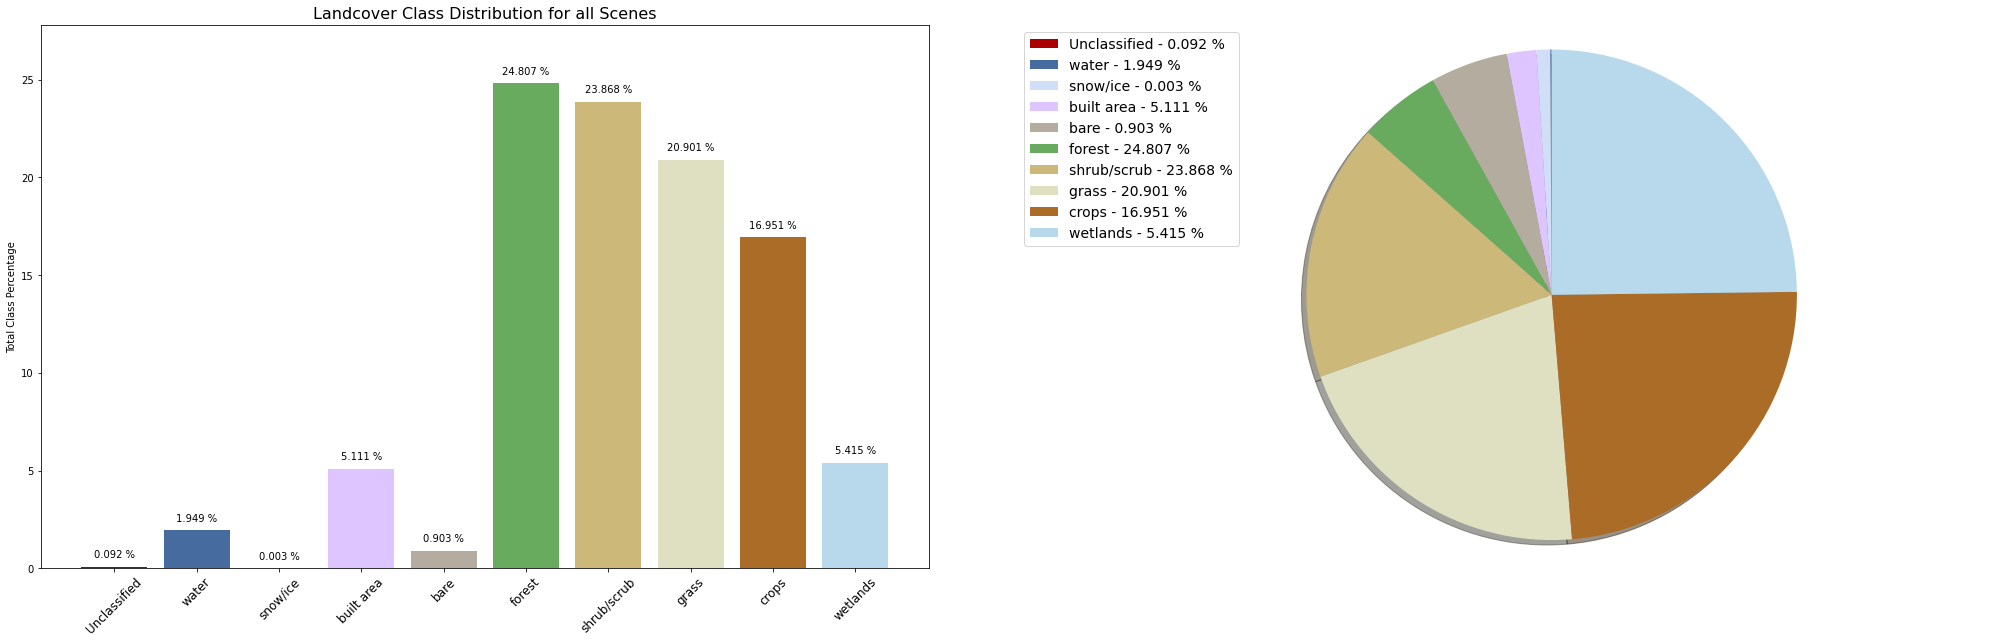

In [ ]:
# plot class distribution
fig_classes, ax_classes = plt.subplots(1, 2, figsize=(35, 10))
ax_classes = ax_classes.ravel()

ax_classes[0].bar(class_counts[0], (100 / np.sum(class_counts[1])) * np.array(class_counts[1]), color=new_colors)
ax_classes[0].set_xticks(list(tgt_cat_names.keys()))
ax_classes[0].set_xticklabels(list(tgt_cat_names.values()), rotation=45, fontsize=12);
ax_classes[0].set_ylabel("Total Class Percentage")
ax_classes[0].set_ylim([0, np.max((100 / np.sum(class_counts[1])) * np.array(class_counts[1])) + 3])
ax_classes[0].set_title("Landcover Class Distribution for all Scenes", fontsize=16)

#https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib

for patch  in ax_classes[0].patches:
    width = patch.get_width()
    height = patch.get_height()
    x, y = patch.get_xy() 
    ax_classes[0].annotate("%0.3f %%" % (height), (x + width/2, y + height + 0.45), ha='center')

patches, _ = ax_classes[1].pie(np.sort((100 / np.sum(class_counts[1])) * np.array(class_counts[1])),
                  shadow=True,
                  startangle=90,
                  colors=new_colors)

#https://stackoverflow.com/questions/23577505/how-to-avoid-overlapping-of-labels-autopct-in-a-matplotlib-pie-chart
labels = ['{0} - {1:1.3f} %'.format(i,j) for i,j in zip(tgt_cat_names.values(), (100 / np.sum(class_counts[1])) * np.array(class_counts[1]))]

plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(-0.1, 1.),
           fontsize=14)

ax_classes[1].axis('equal');

From the class statistics shown above, we can see that our dataset is definitely not balanced. We have 4 dominant classes (e.g., forest, shrub/scrub, grass, and crops). 

Interestingly, our data shows *0.003%* snow/ice pixels. That is a bit suspicious... Let's compute the statistics using the original class labels for a sanity check. In the original class labels, snow/ice mapped one-to-one to the new labels, and thus, if we confirm the pixel count in the original dataset, then we know our results shown above make sense. 

In [ ]:
# check the original targets list/stack
print(orig_tgts_stack[0].shape)

test = np.stack(orig_tgts_stack, axis=0)
print(test.shape)

orig_class_counts = np.unique(test, return_counts=True)

#print(orig_class_counts)

# NLCD class mapping
orig_name_mapping = {
    0:  'Unclassfied',
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands',
}

orig_cls_cnt_dict = {
    "Label" : list(orig_class_counts[0]),
    "Class" : list(orig_name_mapping.values()),
    "Count" : list(orig_class_counts[1])
}

orig_class_cnt_df = pd.DataFrame.from_dict(cls_cnt_dict)
orig_class_cnt_df.set_index("Label")

print("Original Pixel Count Summary\n")
print(tabulate(orig_class_cnt_df, headers='keys', tablefmt='psql'))


(1, 256, 256)
(1340, 1, 256, 256)
Original Pixel Count Summary

+----+---------+--------------+----------+
|    |   Label | Class        |    Count |
|----+---------+--------------+----------|
|  0 |       0 | Unclassified |    80481 |
|  1 |       1 | water        |  1711825 |
|  2 |       2 | snow/ice     |     2458 |
|  3 |       3 | built area   |  4488630 |
|  4 |       4 | bare         |   793007 |
|  5 |       5 | forest       | 21785414 |
|  6 |       6 | shrub/scrub  | 20960074 |
|  7 |       7 | grass        | 18354751 |
|  8 |       8 | crops        | 14886453 |
|  9 |       9 | wetlands     |  4755147 |
+----+---------+--------------+----------+


**Original Class Distribution**

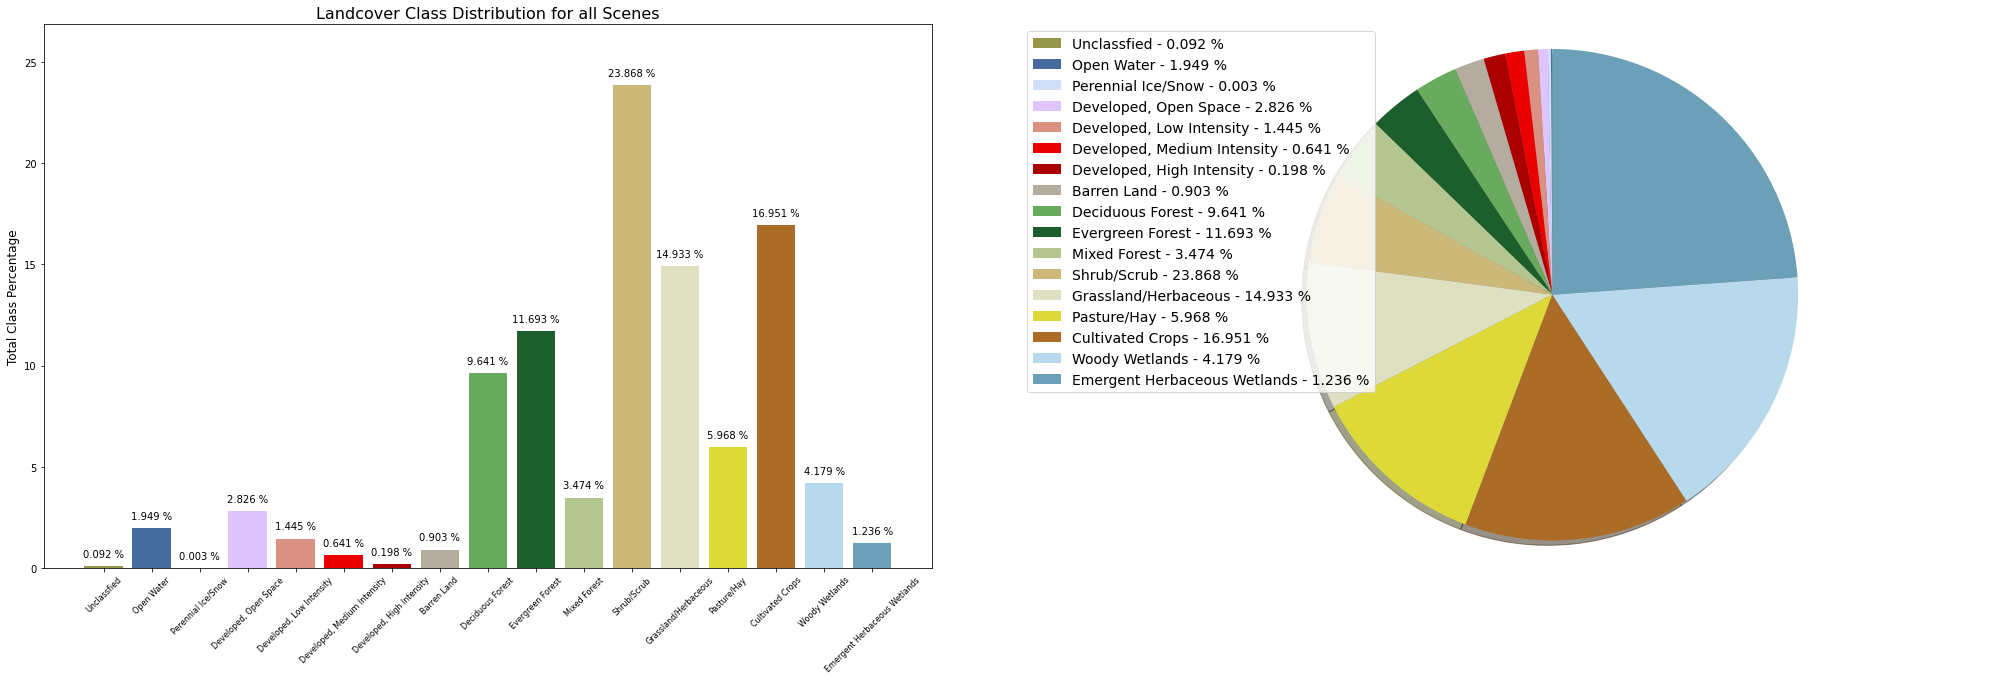

In [ ]:
# NLCD color scheme
nlcd_color_mapping = {
    0:  (150, 150, 75),
    11: (70, 107, 159),
    12: (209, 222, 248),
    21: (222, 197, 255),
    22: (217, 146, 130),
    23: (235, 0, 0),
    24: (171, 0, 0),
    31: (179, 172, 159),
    41: (104, 171, 95),
    42: (28, 95, 44),
    43: (181, 197, 143),
    52: (204, 184, 121),
    71: (223, 223, 194),
    81: (220, 217, 57),
    82: (171, 108, 40),
    90: (184, 217, 235),
    95: (108, 159, 184),
}

# build a matplotlib colormap so we can visualize this data
orig_colors = list()
for idx, class_val in enumerate(nlcd_color_mapping.keys()):
  red, green, blue = nlcd_color_mapping[class_val]

  color_vec = np.array([red/255, green/255, blue/255])
  orig_colors.append(color_vec)


# plot class distribution
fig_orig_classes, ax_orig_classes = plt.subplots(1, 2, figsize=(35, 10))
ax_orig_classes = ax_orig_classes.ravel()


ax_orig_classes[0].bar(np.arange(len(orig_name_mapping.keys())), (100 / np.sum(orig_class_counts[1])) * np.array(orig_class_counts[1]), color=orig_colors)
ax_orig_classes[0].set_xticks(np.arange(len(orig_name_mapping.keys())))
ax_orig_classes[0].set_xticklabels(list(orig_name_mapping.values()), rotation=45, fontsize=8);
ax_orig_classes[0].set_ylabel("Total Class Percentage", fontsize=12)
ax_orig_classes[0].set_ylim([0, np.max((100 / np.sum(orig_class_counts[1])) * np.array(orig_class_counts[1])) + 3])
ax_orig_classes[0].set_title("Landcover Class Distribution for all Scenes", fontsize=16)

for patch  in ax_orig_classes[0].patches:
    width = patch.get_width()
    height = patch.get_height()
    x, y = patch.get_xy() 
    ax_orig_classes[0].annotate("%0.3f %%" % (height), (x + width/2, y + height + 0.45), ha='center')

patches, _ = ax_orig_classes[1].pie(np.sort((100 / np.sum(orig_class_counts[1])) * np.array(orig_class_counts[1])),
                  shadow=True,
                  startangle=90,
                  colors=orig_colors)

labels = ['{0} - {1:1.3f} %'.format(i,j) for i,j in zip(orig_name_mapping.values(), (100 / np.sum(orig_class_counts[1])) * np.array(orig_class_counts[1]))]

plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(-0.1, 1.),
           fontsize=14)

ax_orig_classes[1].axis('equal');

From the original class statistics shown above, we confirm that the perrennial ice/snow pixel distribution is indeed 0.003%. 


#### Spatial Distribution

**Let me now extract the centroids of all my rasters so I can get a sanse of 
the spatial distribution of my data**

In [ ]:
# exploratory....
with rasterio.open(samples[0][0]) as src:
  img = src.read()

# confirm I can extract the CRS and centroid from my rasters
print(type(img))
print(type(src))
print(src.crs)
print(src.xy(src.height // 2, src.width // 2))

<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
EPSG:32612
(302825.0, 3661455.0)


Now loop through all the datasets and store their centroids and projections. I need to verify whether all my rasters share the same projection.

In [ ]:
# create list to store centroids
centroids = list()

for sample in tqdm(samples, position=0):
    with rasterio.open(sample[0]) as src:
        centroid = src.xy(src.height // 2, src.width // 2)
        centroids.append([src.crs, np.array([centroid[0]]), np.array([centroid[1]])])

100%|██████████| 1340/1340 [14:03<00:00,  1.59it/s]


Now, create a GeoPandas dataframe that 

In [ ]:
centroids_df = pd.DataFrame(centroids, columns=['CRS','Centroid X', 'Centroid Y'])
centroids_df.head(6)


CRS  Centroid X   Centroid Y
0  (init)  [302825.0]  [3661455.0]
1  (init)  [320465.0]  [3688635.0]
2  (init)  [416405.0]  [4149795.0]
3  (init)  [673265.0]  [4907595.0]
4  (init)  [636185.0]  [5006235.0]
5  (init)  [458165.0]  [3747495.0]

**Extract CRS Information**

In [ ]:
# extract CRS from each raster
crs_list = [str(centroids[i][0]) for i in range(len(centroids))]

# determine unique CRS strings
unique_crs = list(set(crs_list))
print("Unique CRS' used: \n", unique_crs, "\n\n")
print("There are %d unique CRS in my dataset" % (len(unique_crs)))

Unique CRS' used: 
 ['EPSG:32619', 'EPSG:32612', 'EPSG:32613', 'EPSG:32611', 'EPSG:32614', 'EPSG:32617', 'EPSG:32618', 'EPSG:32615', 'EPSG:32616', 'EPSG:32610'] 


There are 10 unique CRS in my dataset


**Reprojecting my centroids with rasterio before creating my geo-dataframe**

In [ ]:
#import rasterio.crs
# define CRS to be used for displaying spatial distribution
#my_crs = rasterio.crs.CRS.from_dict(init='epsg:4326')
my_crs = rasterio.crs.CRS.from_epsg(4326)

# try it out with one raster first
test_reproj_x, test_reproj_y = rasterio.warp.transform(centroids[0][0], my_crs, centroids[0][1], centroids[0][1], zs=None)
print(test_reproj_x, test_reproj_y)
print(type(test_reproj_x))

[-112.7736901945058] [2.738412330415714]
<class 'list'>


In [ ]:
reproj_centroids = list()

for ctroid in tqdm(centroids, position=0):
    x, y = rasterio.warp.transform(ctroid[0], my_crs, ctroid[1], ctroid[2], zs=None)
    #x, y = rasterio.warp.transform(ctroid[0], {'init': 'epsg:32618'}, ctroid[1], ctroid[2], zs=None)
    reproj_centroids.append([np.array(x), np.array(y)])

100%|██████████| 1340/1340 [00:00<00:00, 1411.40it/s]


**Raster Dates Statistics**

In [ ]:
# my filenames have dates, don't they?
print(samples[0])
print(samples[1])
print(samples[2])

import rasterio.rio
with rasterio.open(samples[0][0]) as src:
  img = src.read()
print(type(img))
print(type(src))
print(src.meta)

('https://storage.googleapis.com/naip_public/images/landsat:LC08:PRE:TOAR_6:125:30.0:12:-1096:20341.tif', 'https://storage.googleapis.com/naip_public/targets_v2/nlcd:land_cover_6:125:30.0:12:-1096:20341.tif')
('https://storage.googleapis.com/naip_public/images/landsat:LC08:PRE:TOAR_6:125:30.0:15:-998:20492.tif', 'https://storage.googleapis.com/naip_public/targets_v2/nlcd:land_cover_6:125:30.0:15:-998:20492.tif')
('https://storage.googleapis.com/naip_public/images/landsat:LC08:PRE:TOAR_6:125:30.0:17:-465:23054.tif', 'https://storage.googleapis.com/naip_public/targets_v2/nlcd:land_cover_6:125:30.0:17:-465:23054.tif')
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 256, 'height': 256, 'count': 10, 'crs': CRS.from_epsg(32612), 'transform': Affine(30.0, 0.0, 298970.0,
       0.0, -30.0, 3665310.0)}


Now create my Mercator dataframe

In [ ]:
#centroids_mercator_df = pd.DataFrame(reproj_centroids, columns=['X','Y'])
#centroids_mercator_df.head(6)

In [ ]:
# create GeoPandas dataframe
#import geopandas as gpd

In [ ]:
#gdf = gpd.GeoDataFrame(
#    centroids_mercator_df,
#    geometry=gpd.points_from_xy(centroids_mercator_df.X, centroids_mercator_df.Y),
#    crs=4326)

#gdf.head(6)

In [ ]:
#test = list(gdf.geometry)
#print(test)

In [ ]:
#gdf.plot(figsize=(15,15))

In [ ]:
#import contextily as ctx

In [ ]:
#print(gdf.crs)

In [ ]:
#ax = gdf.plot(figsize=(25,17.5), alpha=0.6)
#ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
#ctx.add_basemap(ax,
#               crs=gdf.crs.to_string(),
#               source=ctx.providers.CartoDB.Positron)
#ax.set_axis_off()

In [ ]:
print([float(reproj_centroids[0][1]), float(reproj_centroids[0][0])])
print(float(coord[1]))

[33.07382285906529, -113.1122895118087]
4444712.322112706


In [ ]:
m = folium.Map(location=[46, -102], zoom_start=5, tiles='cartodbpositron')

folium.CircleMarker(
    location=[float(reproj_centroids[0][1]), float(reproj_centroids[0][0])],
    radius=7,
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

folium.LayerControl().add_to(m)

for coord in reproj_centroids:
    folium.CircleMarker(
        location=[float(coord[1]), float(coord[0])],
        radius=5,
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        ).add_to(m)

    #folium.LayerControl().add_to(m)


m

### Visualization

In [7]:
# NLCD color scheme
nlcd_color_mapping = {
    11: (70, 107, 159),
    12: (209, 222, 248),
    21: (222, 197, 255),
    22: (217, 146, 130),
    23: (235, 0, 0),
    24: (171, 0, 0),
    31: (179, 172, 159),
    41: (104, 171, 95),
    42: (28, 95, 44),
    43: (181, 197, 143),
    52: (204, 184, 121),
    71: (223, 223, 194),
    81: (220, 217, 57),
    82: (171, 108, 40),
    90: (184, 217, 235),
    95: (108, 159, 184),
}

# NLCD class mapping
nlcd_name_mapping = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands',
}

In [8]:
# build a matplotlib colormap so we can visualize this data
colors = list()
for idx, class_val in enumerate(nlcd_color_mapping.keys()):
  red, green, blue = nlcd_color_mapping[class_val]

  color_vec = np.array([red/255, green/255, blue/255])
  colors.append(color_vec)

colors = np.stack(colors)
cmap = matplotlib.colors.ListedColormap(colors=colors, N=len(colors))

bounds = list(range(len(colors)))
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

In [168]:
# write a function so that we can display image/target/predictions
def display_image_target(display_list):
  plt.figure(dpi=200)
  title = ['Image', 'Target', 'Prediction']

  for idx, disp in enumerate(display_list):
    plt.subplot(1, len(display_list), idx+1)
    plt.title(title[idx], fontsize=6)
    plt.axis('off')

    if title[idx] == 'Image':
      arr = disp.numpy()
      rgb = np.stack([arr[:, :, 3], arr[:, :, 2], arr[:, :, 1]], axis=-1) / 3000.0
      #rgb = np.stack([arr[:, :, 3], arr[:, :, 2], arr[:, :, 1]], axis=-1) 
      plt.imshow(rgb)

    elif title[idx] == 'Target':
      tgt = disp.numpy().squeeze()
      plt.imshow(tgt, interpolation='none', norm=norm, cmap=cmap)

    elif title[idx] == 'Prediction':
      pred = np.argmax(disp, axis=-1) # argmax across probabilities to get class outputs
      plt.imshow(pred, interpolation='none', norm=norm, cmap=cmap)

  plt.show()
  plt.close()

### Tensorflow dataset loader

In [10]:
# Original read_sample function
'''
def read_sample(data_path: str) -> tuple:
  path = data_path.numpy()
  image_path, target_path = path[0].decode('utf-8'), path[1].decode('utf-8')

  with rasterio.open(image_path) as src:
    img = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint16)

  with rasterio.open(target_path) as src:
    tgt = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint8)

  tgt_out = np.zeros(tgt.shape, dtype=np.uint8)
  for class_val, nlcd_val in enumerate(nlcd_color_mapping.keys()):
    tgt_out[tgt == nlcd_val] = class_val

  return (img, tgt_out)
  '''

"\ndef read_sample(data_path: str) -> tuple:\n  path = data_path.numpy()\n  image_path, target_path = path[0].decode('utf-8'), path[1].decode('utf-8')\n\n  with rasterio.open(image_path) as src:\n    img = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint16)\n\n  with rasterio.open(target_path) as src:\n    tgt = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint8)\n\n  tgt_out = np.zeros(tgt.shape, dtype=np.uint8)\n  for class_val, nlcd_val in enumerate(nlcd_color_mapping.keys()):\n    tgt_out[tgt == nlcd_val] = class_val\n\n  return (img, tgt_out)\n  "

In [11]:
def read_sample(data_path: str) -> tuple:
  path = data_path.numpy()
  image_path, target_path = path[0].decode('utf-8'), path[1].decode('utf-8')

  with rasterio.open(image_path) as src:
    img = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint16)

  with rasterio.open(target_path) as src:
    tgt = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint8)

  tgt_out = np.vectorize(categories_map.get)(tgt)
  #tgt_out = np.zeros(tgt.shape, dtype=np.uint8)
  #for class_val, nlcd_val in enumerate(nlcd_color_mapping.keys()):
  #  tgt_out[tgt == nlcd_val] = class_val

  return (img, tgt_out)

In [12]:
@tf.function
def tf_read_sample(data_path: str) -> dict:
  # wrap custom dataloadeer into tensorflow
  [image, target] = tf.py_function(read_sample, [data_path], [tf.uint16, tf.uint8])

  # explicitly set tensor shapes
  image.set_shape((256, 256, 10))
  target.set_shape((256, 256, 1))

  return {'image': image, 'target': target}

In [209]:
@tf.function
def load_sample(sample: dict) -> tuple:
  # convert to tf image
  image = tf.image.resize(sample['image'], (256, 256))
  target = tf.image.resize(sample['target'], (256, 256))

  # cast to proper data types
  image = tf.cast(image, tf.float32)
  mean = tf.math.reduce_mean(image, axis=(0, 1))
  std = tf.math.reduce_std(image, axis=(0, 1))
  image = (image - mean) / (std + 1e-10) 
  #image = (image - tf.math.reduce_min(image, axis=(0, 1))) / (tf.math.reduce_max(image, axis=(0, 1)) - tf.math.reduce_min(image, axis=(0, 1)))
  target = tf.cast(target, tf.uint8)

  return image, target

In [210]:
# create tensorflow dataset from file links
ds = tf.data.Dataset.from_tensor_slices(samples)

# read in image/target pairs
ds = ds.map(tf_read_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# read in as tensors
ds = ds.map(load_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


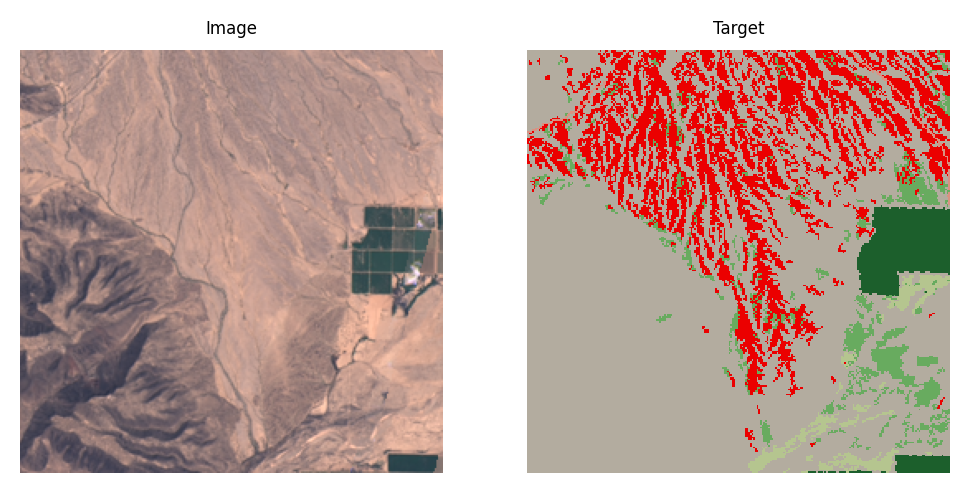

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


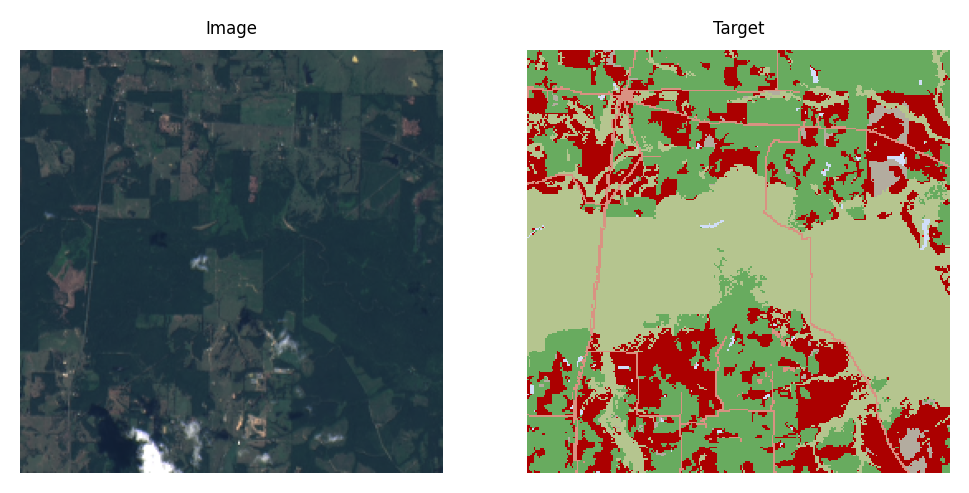

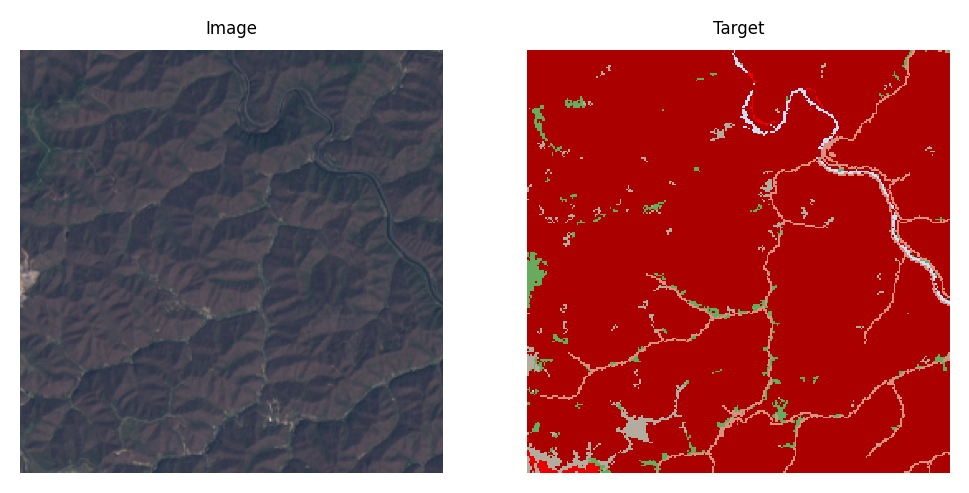

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


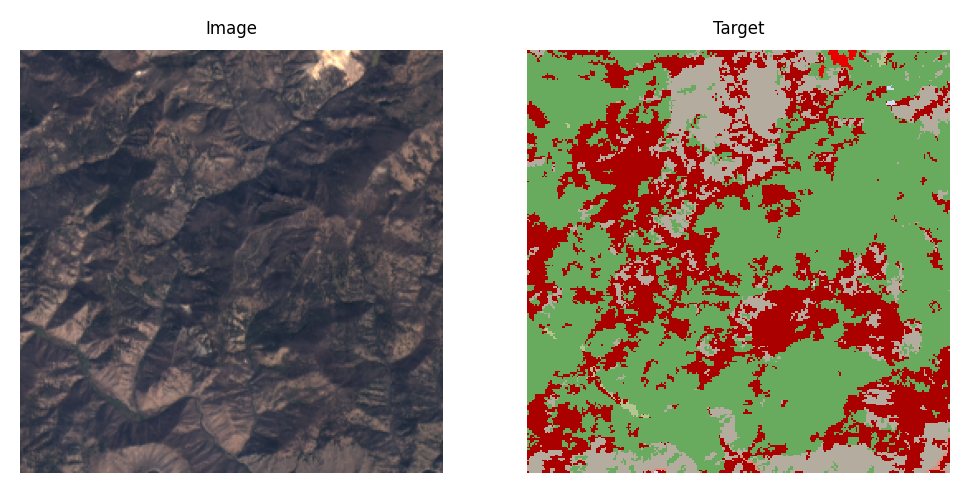

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


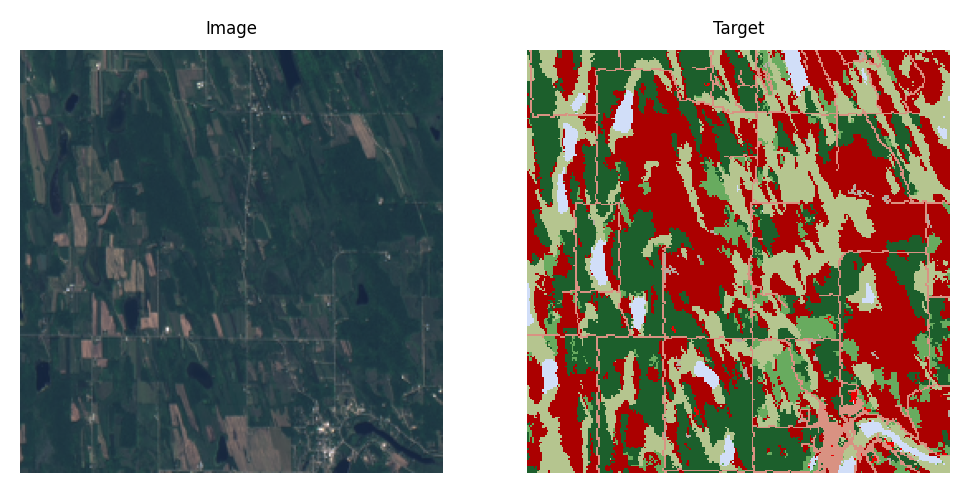

In [182]:
for image, target in ds.take(5):
  display_image_target([image, target])

In [186]:
num_take = 1
for im, tg in ds.take(num_take):

    scaler = np.max(im, axis=-1)
    #print(np.min(im))
    a = im.numpy()
    b = im
    t = tg.numpy()

In [190]:
mean = tf.math.reduce_mean(b, axis=(0, 1))
print(mean)
std = tf.math.reduce_std(b, axis=(0, 1))
print(std)

normalized = (b - mean) / (std + 1e-10)
print(tf.math.reduce_max(normalized, axis=(0, 1)))
print(tf.math.reduce_min(normalized, axis=(0, 1)))


tf.Tensor(
[1.5950024e+03 1.5195469e+03 1.5874432e+03 1.9212119e+03 2.6315579e+03
 2.9342373e+03 2.6095684e+03 1.4134537e+04 3.8146973e-04 6.5535000e+04], shape=(10,), dtype=float32)
tf.Tensor(
[1.8460666e+02 2.4819925e+02 3.3815744e+02 4.9338928e+02 6.6636963e+02
 6.0581702e+02 6.1968542e+02 6.5943402e+02 1.9527519e-02 0.0000000e+00], shape=(10,), dtype=float32)
tf.Tensor(
[ 7.486174   6.1017637  3.7454648  2.7945237  5.502115   2.601054
  2.8263237  2.5225616 51.190247   0.       ], shape=(10,), dtype=float32)
tf.Tensor(
[-2.9305685  -3.1528978  -3.0501864  -2.9919822  -3.008177   -3.60379
 -3.3719823  -6.50791    -0.01953498  0.        ], shape=(10,), dtype=float32)


In [185]:
print(type(b))
print(tf.math.reduce_max(b, axis=(0, 1)))
print(tf.math.reduce_min(b, axis=(0, 1)))

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[2.9770e+03 3.0340e+03 2.8540e+03 3.3000e+03 6.2980e+03 4.5100e+03
 4.3610e+03 1.5798e+04 1.0000e+00 6.5535e+04], shape=(10,), dtype=float32)
tf.Tensor([ 1054.   737.   556.   445.   627.   751.   520.  9843.     0. 65535.], shape=(10,), dtype=float32)


In [176]:
from tensorflow.keras.layers.experimental import preprocessing

normalizer = preprocessing.Normalization()
normalizer.adapt(b)
normalized_b = normalizer(b)

In [179]:
print(b.shape)
print(type(b))
print(tf.math.reduce_max(b, axis=(0, 1)))
print(tf.math.reduce_min(b, axis=(0, 1)))
print("\n")
print(normalized_b.shape)
print(type(normalized_b))
print(tf.math.reduce_max(normalized_b, axis=(0, 1)))
print(tf.math.reduce_min(normalized_b, axis=(0, 1)))

(256, 256, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[2.9770e+03 3.0340e+03 2.8540e+03 3.3000e+03 6.2980e+03 4.5100e+03
 4.3610e+03 1.5798e+04 1.0000e+00 6.5535e+04], shape=(10,), dtype=float32)
tf.Tensor([ 1054.   737.   556.   445.   627.   751.   520.  9843.     0. 65535.], shape=(10,), dtype=float32)


(256, 256, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[ 7.486174   6.1017632  3.7454648  2.7945237  5.502115   2.601054
  2.8263233  2.5225601 51.19023    0.       ], shape=(10,), dtype=float32)
tf.Tensor(
[-2.9305685  -3.1528983  -3.0501864  -2.9919825  -3.008177   -3.60379
 -3.3719828  -6.507911   -0.01953498  0.        ], shape=(10,), dtype=float32)


In [164]:
#test = tf.keras.utils.normalize(b)
test = b
print(test.shape)
print(type(test))
print(tf.math.reduce_max(test, axis=(0, 1)))
print(tf.math.reduce_min(test, axis=(0, 1)))

(256, 256, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[2.9770e+03 3.0340e+03 2.8540e+03 3.3000e+03 6.2980e+03 4.5100e+03
 4.3610e+03 1.5798e+04 1.0000e+00 6.5535e+04], shape=(10,), dtype=float32)
tf.Tensor([ 1054.   737.   556.   445.   627.   751.   520.  9843.     0. 65535.], shape=(10,), dtype=float32)


In [166]:
test = tf.keras.utils.normalize(b, axis=(0,1))
print(test.shape)
print(type(test))
print(tf.math.reduce_max(test, axis=(0, 1)))
print(tf.math.reduce_min(test, axis=(0, 1)))

(256, 256, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[0.00727084 0.00776104 0.00696479 0.00663773 0.00921332 0.00596081
 0.00647438 0.00436496 0.27201575 0.00390625], shape=(10,), dtype=float32)
tf.Tensor(
[0.00257423 0.00188526 0.00135684 0.00089509 0.00091724 0.00099259
 0.000772   0.00271961 0.         0.00390625], shape=(10,), dtype=float32)


In [154]:
e = b / tf.math.reduce_max(b, axis=(0, 1))
print(tf.math.reduce_min(b, axis=(0, 1)))
print(tf.math.reduce_max(e, axis=(0, 1)))
scaled = (b - tf.math.reduce_min(b, axis=(0, 1))) / (tf.math.reduce_max(e, axis=(0, 1)) - tf.math.reduce_min(b, axis=(0, 1)))

tf.Tensor([ 0.  0.  0.  0.  0.  0.  0.  0.  0. nan], shape=(10,), dtype=float32)
tf.Tensor([ 1.  1.  1.  1.  1.  1.  1.  1.  1. nan], shape=(10,), dtype=float32)


In [113]:
print(b)
print(type(a))
print(type(scaler))
print(scaler.shape)
#plt.imshow(a)

tf.Tensor(
[[[ 1640.  1619.  1727. ... 14240.     0. 65535.]
  [ 1714.  1691.  1802. ... 14232.     0. 65535.]
  [ 1723.  1630.  1733. ... 14215.     0. 65535.]
  ...
  [ 1741.  1712.  1807. ... 14388.     0. 65535.]
  [ 1749.  1679.  1782. ... 14396.     0. 65535.]
  [ 1749.  1690.  1793. ... 14400.     0. 65535.]]

 [[ 1647.  1578.  1664. ... 14239.     0. 65535.]
  [ 1704.  1689.  1772. ... 14231.     0. 65535.]
  [ 1701.  1608.  1693. ... 14214.     0. 65535.]
  ...
  [ 1755.  1699.  1792. ... 14381.     0. 65535.]
  [ 1756.  1686.  1784. ... 14388.     0. 65535.]
  [ 1755.  1720.  1820. ... 14395.     0. 65535.]]

 [[ 1612.  1471.  1552. ... 14238.     0. 65535.]
  [ 1682.  1696.  1783. ... 14229.     0. 65535.]
  [ 1693.  1633.  1729. ... 14213.     0. 65535.]
  ...
  [ 1760.  1729.  1809. ... 14379.     0. 65535.]
  [ 1760.  1719.  1812. ... 14384.     0. 65535.]
  [ 1758.  1719.  1817. ... 14391.     0. 65535.]]

 ...

 [[ 1402.  1287.  1278. ... 14179.     0. 65535.]
  [ 1494.

In [118]:
c = b.numpy()
print(np.max(c,axis=(0,1)))
print(tf.math.reduce_max(b, axis=(0,1)))

[2.9770e+03 3.0340e+03 2.8540e+03 3.3000e+03 6.2980e+03 4.5100e+03
 4.3610e+03 1.5798e+04 1.0000e+00 6.5535e+04]
tf.Tensor(
[2.9770e+03 3.0340e+03 2.8540e+03 3.3000e+03 6.2980e+03 4.5100e+03
 4.3610e+03 1.5798e+04 1.0000e+00 6.5535e+04], shape=(10,), dtype=float32)


In [143]:
print(np.min(t))
print(np.max(t))

3
9


**U-Net Model**

https://www.tensorflow.org/tutorials/images/segmentation

In [16]:
# define number of classes
NUM_CHAN = len(tgt_cat_names)

a = ds.take(1)
print(a)
# load pretrained MobileNetV2 model from keras
#base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 10], include_top=False)

<TakeDataset shapes: ((256, 256, 10), (256, 256, 1)), types: (tf.float32, tf.uint8)>


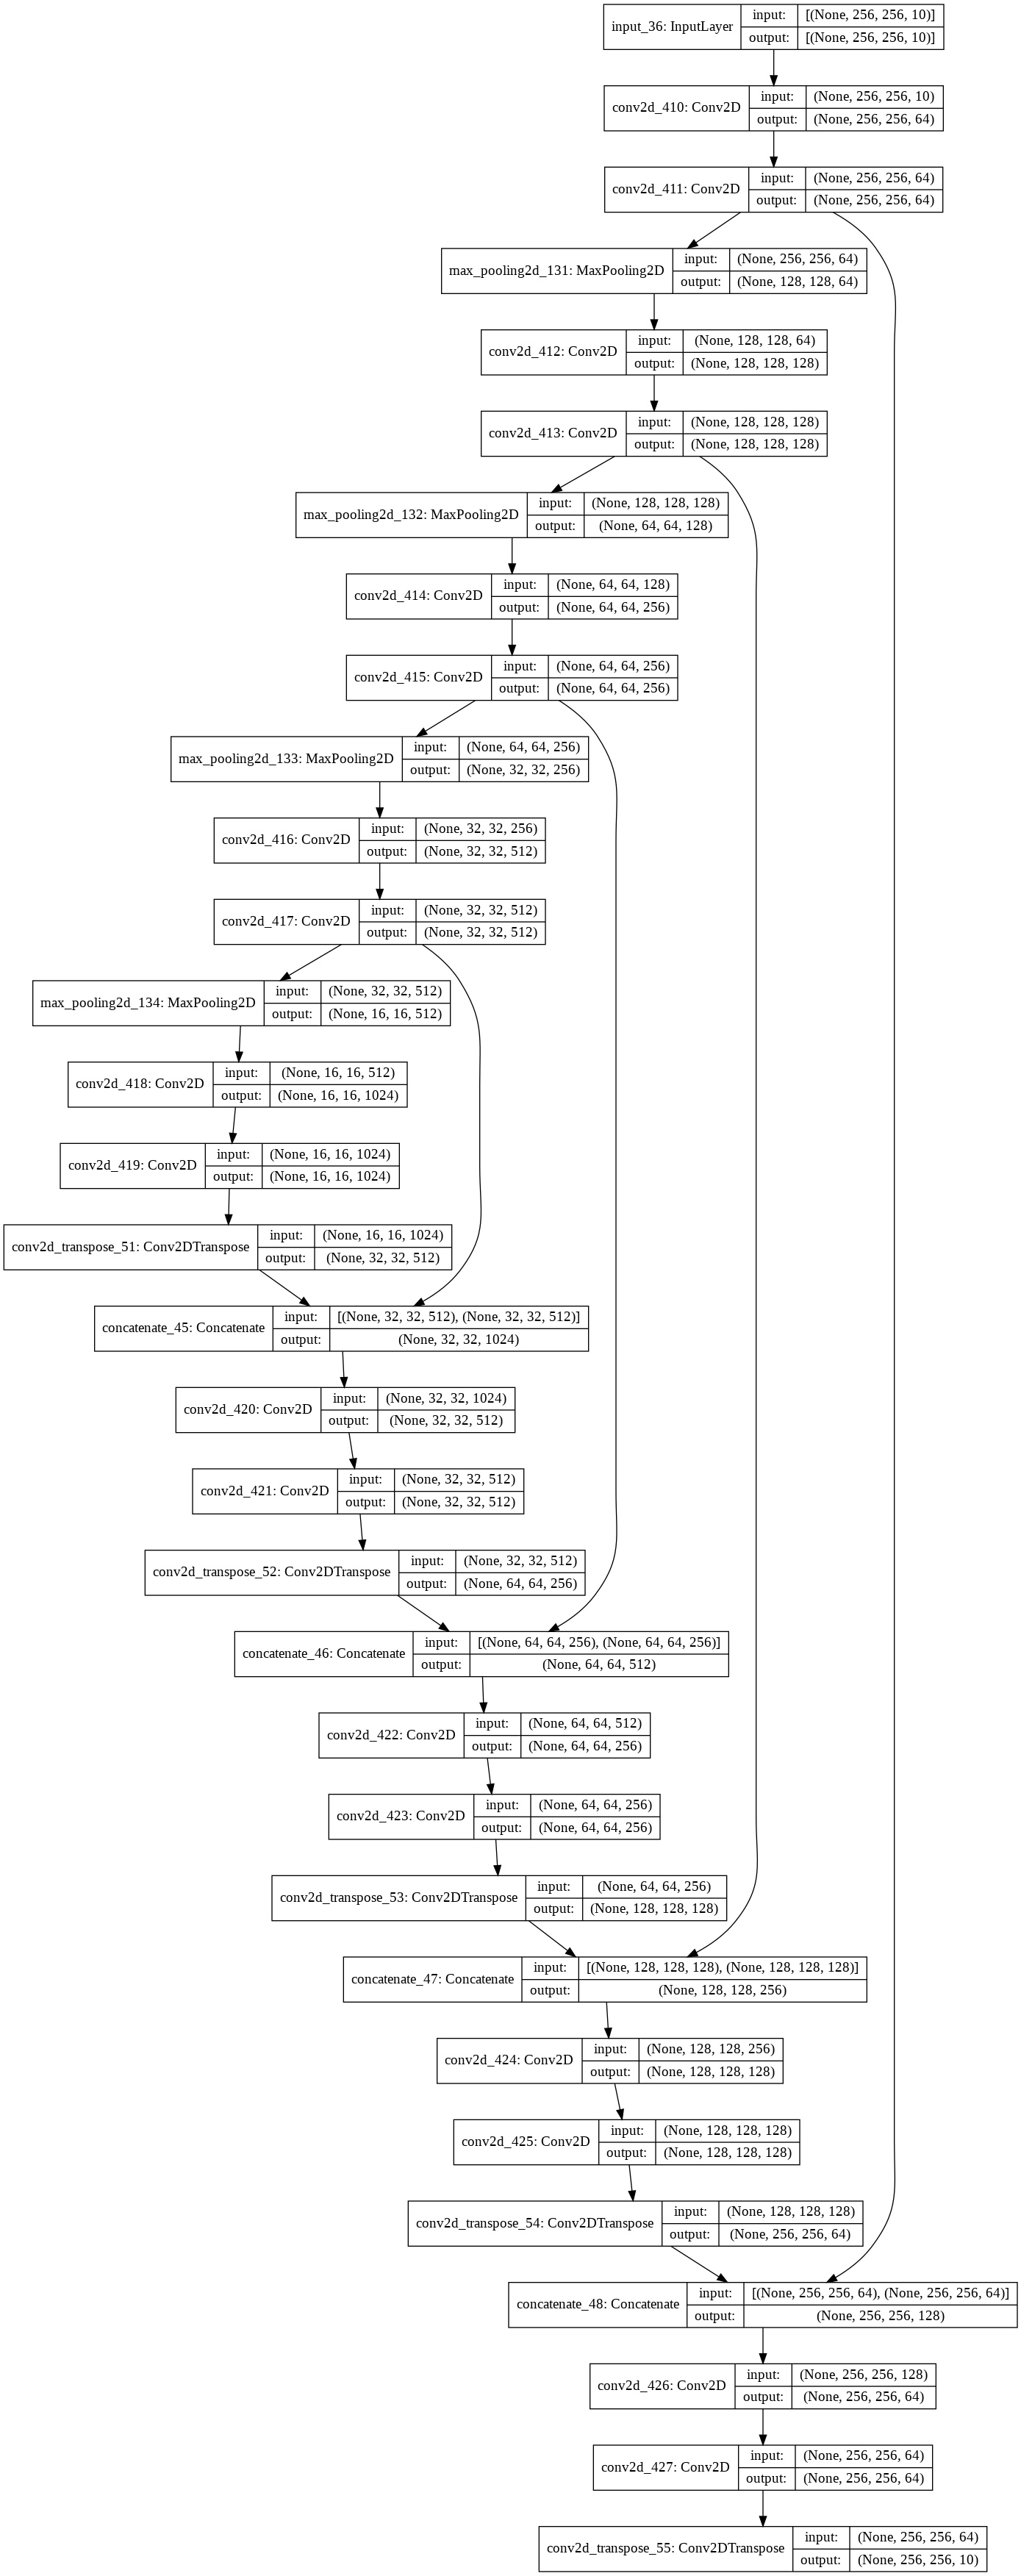

In [206]:
inputs = tf.keras.layers.Input(shape=(256, 256, 10))

# DOWNSAMPLING

# block 1
conv_block_1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
conv_block_1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_1)
conv_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block_1)

# block 2
conv_block_2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(conv_pool_1)
conv_block_2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),  activation='relu', padding='same')(conv_block_2)
conv_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block_2)

# block 3
conv_block_3 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(conv_pool_2)
conv_block_3 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_3)
conv_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block_3)

# block 4
conv_block_4 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(conv_pool_3)
conv_block_4 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_4)
conv_pool_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_block_4)

# block 5
conv_block_5 = tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(conv_pool_4)
conv_block_5 = tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_5)

# UPSAMPLING

# block 6
up_conv_6 = tf.keras.layers.Concatenate()([conv_block_4, tf.keras.layers.Conv2DTranspose(512, kernel_size=(2, 2), strides=2)(conv_block_5)])
conv_block_6 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(up_conv_6)
conv_block_6 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_6)

# block 7
up_conv_7 = tf.keras.layers.Concatenate()([conv_block_3, tf.keras.layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=2)(conv_block_6)])
conv_block_7 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(up_conv_7)
conv_block_7 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_7)

# block 8
up_conv_8 = tf.keras.layers.Concatenate()([conv_block_2, tf.keras.layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=2)(conv_block_7)])
conv_block_8 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(up_conv_8)
conv_block_8 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_8)

# block 9
up_conv_9 = tf.keras.layers.Concatenate()([conv_block_1, tf.keras.layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=2)(conv_block_8)])
conv_block_9 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(up_conv_9)
conv_block_9 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(conv_block_9)

# output layer
last = tf.keras.layers.Conv2DTranspose(10, 10, strides=1, padding='same')(conv_block_9)

model = tf.keras.Model(inputs=inputs, outputs=last)

tf.keras.utils.plot_model(model, show_shapes=True)


In [207]:
# compile model
optim = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

model.compile(optimizer=optim,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test

In [211]:
DATASET_SIZE = len(samples)
print(DATASET_SIZE)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

#full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
#full_dataset = full_dataset.shuffle()
train_dataset = ds.take(train_size)
test_dataset = ds.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

1340


In [212]:
EPOCHS = 2
train_dataset = train_dataset.shuffle(buffer_size=128).batch(10)
val_dataset = val_dataset.batch(10)

model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/2
94/94 [==============================] - 158s 2s/step - loss: 2.2238 - accuracy: 0.1438 - val_loss: 1.8292 - val_accuracy: 0.2980
Epoch 2/2
94/94 [==============================] - 144s 1s/step - loss: 1.8120 - accuracy: 0.2814 - val_loss: 1.7590 - val_accuracy: 0.3075


In [213]:
test_dataset = test_dataset.batch(10)
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

21/21 [==============================] - 76s 689ms/step - loss: 1.7655 - accuracy: 0.2992


{'accuracy': 0.29918938875198364, 'loss': 1.765547275543213}

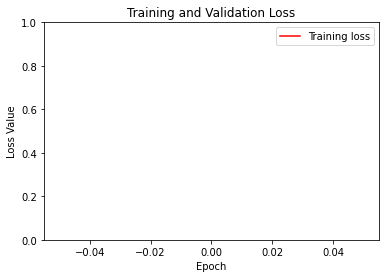

In [73]:
#print(type(model_history))
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

EPOCHS = 5
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
#plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
#https://www.kaggle.com/ceperaang/lb-0-42-ultimate-full-solution-run-on-your-hw
from keras.models import Model, load_model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

def get_unet():
    #inputs = Input((8, ISZ, ISZ))
    inputs = Input((256, 256, 10))
    conv1 = Convolution2D(32, 3, 3, activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', padding='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', padding='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', padding='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', padding='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', padding='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', padding='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', padding='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', padding='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', padding='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    #model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

In [ ]:
'''
concat = tf.keras.layers.Concatenate()

inputs = tf.keras.layers.Input(shape=[None, None, NUM_CHAN])
conv1 = tf.keras.layers.Conv2D(32, 3, 3, activation='relu', padding='same')(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, 3, activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, 3, 3, activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Conv2D(64, 3, 3, activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, 3, 3, activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Conv2D(128, 3, 3, activation='relu', padding='same')(conv3)
pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(256, 3, 3, activation='relu', padding='same')(pool3)
conv4 = tf.keras.layers.Conv2D(256, 3, 3, activation='relu', padding='same')(conv4)
pool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv4)

conv5 = tf.keras.layers.Conv2D(512, 3, 3, activation='relu', padding='same')(pool4)
conv5 = tf.keras.layers.Conv2D(512, 3, 3, activation='relu', padding='same')(conv5)

up6 = tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
#up6 = tf.keras.layers.Concatenate([tf.keras.layers.Conv2DTranspose(size=(2, 2))(conv5), conv4])

up6 = concat([tf.keras.layers.Conv2DTranspose(size=(2, 2))(conv5), conv4])
conv6 = tf.keras.layers.Conv2D(256, 3, 3, activation='relu', padding='same')(up6)
conv6 = tf.keras.layers.Conv2D(256, 3, 3, activation='relu', padding='same')(conv6)




model = tf.keras.Model(inputs=inputs, outputs=conv6)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

'''

"\nconcat = tf.keras.layers.Concatenate()\n\ninputs = tf.keras.layers.Input(shape=[None, None, NUM_CHAN])\nconv1 = tf.keras.layers.Conv2D(32, 3, 3, activation='relu', padding='same')(inputs)\nconv1 = tf.keras.layers.Conv2D(32, 3, 3, activation='relu', padding='same')(conv1)\npool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)\n\nconv2 = tf.keras.layers.Conv2D(64, 3, 3, activation='relu', padding='same')(pool1)\nconv2 = tf.keras.layers.Conv2D(64, 3, 3, activation='relu', padding='same')(conv2)\npool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)\n\nconv3 = tf.keras.layers.Conv2D(128, 3, 3, activation='relu', padding='same')(pool2)\nconv3 = tf.keras.layers.Conv2D(128, 3, 3, activation='relu', padding='same')(conv3)\npool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv3)\n\nconv4 = tf.keras.layers.Conv2D(256, 3, 3, activation='relu', padding='same')(pool3)\nconv4 = tf.keras.layers.Conv2D(256, 3, 3, activation='relu', padding='same')(conv4)\npool4 = tf.keras.layers.Max

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size):
  """Downsamples an input.
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, activation='relu', padding='same',
                             kernel_initializer=initializer))
  
  result.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  return result


def upsample(filters, size):
  """Upsamples an input.
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer))
  result.add(tf.keras.layers.ReLU())

  return result



In [ ]:
down_stack = [
      downsample(64, 4),  # (bs, 128, 128, 64)
      downsample(128, 4),  # (bs, 64, 64, 128)
      downsample(256, 4),  # (bs, 32, 32, 256)
      downsample(512, 4),  # (bs, 16, 16, 512)
      downsample(512, 4),  # (bs, 8, 8, 512)
      downsample(512, 4),  # (bs, 4, 4, 512)
      downsample(512, 4),  # (bs, 2, 2, 512)
      downsample(512, 4),  # (bs, 1, 1, 512)
  ]

up_stack = [
      upsample(512, 4),  # (bs, 2, 2, 1024)
      upsample(512, 4),  # (bs, 4, 4, 1024)
      upsample(512, 4),  # (bs, 8, 8, 1024)
      upsample(512, 4),  # (bs, 16, 16, 1024)
      upsample(256, 4),  # (bs, 32, 32, 512)
      upsample(128, 4),  # (bs, 64, 64, 256)
      upsample(64, 4),  # (bs, 128, 128, 128)
  ]

In [ ]:

def unet_generator(output_channels):
    """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
    Args:
        output_channels: Output channels
        norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    Returns:
        Generator model
    """

    down_stack = [
        downsample(64, 4),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4),  # (bs, 2, 2, 1024)
        upsample(512, 4),  # (bs, 4, 4, 1024)
        upsample(512, 4),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 4, strides=2,
        padding='same', kernel_initializer=initializer,
        activation='tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None, None, 10])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
test_model = unet_generator(10)

In [ ]:
#model = tf.keras.Model(inputs=inputs, outputs=conv6)

test_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])


In [ ]:

EPOCHS = 20
#TRAIN_LENGTH = info.splits['train'].num_examples
#BATCH_SIZE = 64
#BUFFER_SIZE = 1000
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(ds, epochs=EPOCHS)

Epoch 1/20


ValueError: ignored